In [1]:
%matplotlib notebook

import os
import time
import numpy as np
import matplotlib as mpl

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

from labtools import mplplots; reload(mplplots)
from labtools.mplplots.init_nb_plotting import *
from labtools.mplplots import tools as mpltools

import qcodes as qc
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
from qcodes.sweep import sweep, nest, chain, szip, getter, setter
from qcodes.sweep.sweep import ParameterSweep, Nest, ParameterWrapper, FunctionWrapper, FunctionSweep, getter
from pytopo.qctools import instruments as instools

from v2_dataset_tools.experiments import do_experiment, get_results_from_db_path

In [2]:
from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin
from scipy.integrate import cumtrapz

In [3]:
from qcodes.dataset.sqlite_base import transaction, one

def get_timestamp(run_id):
    DB = qc.config["core"]["db_location"]
    
    d = DataSet(DB)
    sql = """
    SELECT run_timestamp
    FROM
      runs
    WHERE
      run_id= ?
    """
    c = transaction(d.conn, sql, run_id)
    run_timestamp = one(c, 'run_timestamp')
    return run_timestamp

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "d:/data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

In [4]:
from qcodes.instrument_drivers.QuTech.IVVI import IVVI
ivvi = instools.create_inst(IVVI, "ivvi", "ASRL5::INSTR")

from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
key1 = instools.create_inst(Keysight_34465A, "key1", "USB0::0x2A8D::0x0101::MY57503556::INSTR")
# key2 = instools.create_inst(Keysight_34465A, "key2", "USB0::0x2A8D::0x0101::MY57503135::INSTR")

from qcodes.instrument_drivers.stanford_research.SR860 import SR860

lockin1 = instools.create_inst(SR860, "lockin1", "GPIB0::3::INSTR")
# lockin2 = instools.create_inst(SR860, "lockin2", "GPIB0::4::INSTR")

station = qc.Station(ivvi, key1, lockin1)

Initialized IVVI-rack in 0.10s
Connected to: Keysight Technologies 34465A (serial:MY57503556, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.16s
Connected to: Stanford_Research_Systems SR860 (serial:003104, firmware:V1.47) in 0.07s


In [94]:
def process_data(bias, V_ratio=1e-3):    
    bias    = bias * (V_ratio*1e-3)
    return bias

def fit_resistance(i, v, ilim=None, vlim=None):  
    if ilim is not None:
        fltr = (i>ilim[0]) & (i<ilim[1])
    elif vlim is not None:
        fltr = (v>vlim[0]) & (v<vlim[1])
    else:
        fltr = slice(None, None, None)
        
    i2 = i[fltr]
    v2 = v[fltr]
    
    p = np.polyfit(v2, i2,  1)
    i_fit = np.polyval(p, v2)
    r_fit = 1./p[0]
    
    return v2, i_fit, r_fit

In [93]:
station.ivvi.set_dacs_zero()

In [158]:
@getter([('current', 'A'), ('L1X', 'V'), ('L1Y', 'V')])
def measure_dc(gain_Imeas=1e6, gain_Vmeas=200):
    time.sleep(.25 * key1.NPLC()) 
    current = key1.volt()
    L1X     = lockin1.X()
    L1Y     = lockin1.Y()
    result  = current/gain_Imeas, L1X/gain_Imeas, L1Y/gain_Imeas
    return result

<IPython.core.display.Javascript object>


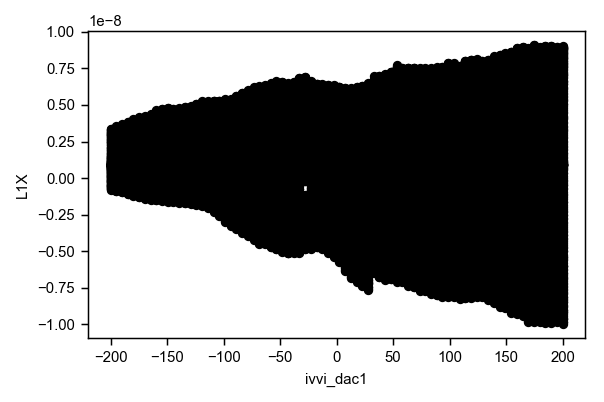

Starting experimental run with id: 139


C:\Users\Administrator\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=200.0, right=200.0
  'left=%s, right=%s') % (left, right))


Completed measurement. Database path: Cq030307M/Cq030307M/54


In [164]:
setup = [(lambda: None, tuple())]
cleanup = [(lambda: None, tuple())]

key1.NPLC(1)

gain_bias = 1e-3
lockin1.amplitude(5*1e-6/(np.sqrt(2)*1e-2*gain_bias))
lockin1.frequency(18.3)
lockin1.time_constant(.1)

station.ivvi.dac1(100)
station.ivvi.dac4(-560)
station.ivvi.dac8(0)

result = do_experiment(
    "Cq030307M/Cq030307M",
    setup,
    nest(
        sweep(ivvi.dac8, np.linspace(200, -200, 80)),
        sweep(ivvi.dac1, np.linspace(-1000, 1000, 201)),
        measure_dc
    ),
    cleanup,
    return_format=["data_set_path", "dataset"], 
    live_plot_axes=[{"ivvi_dac1": 0, "L1X": 2}]
)

92409.3239775


<IPython.core.display.Javascript object>


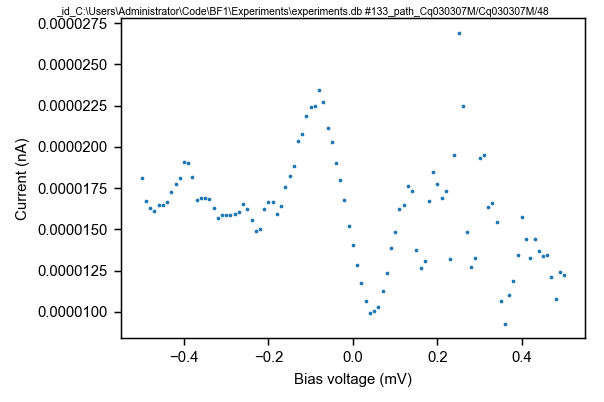

In [151]:
path, ds = result
dv = get_results_from_db_path(path)
dataid = ds.run_id

b_dac = np.array(dv.get_values('ivvi_dac1'))[:,0]
i     = np.array(dv.get_values('current'))[:,0]
b     = process_data(b_dac)
l1x   = np.array(dv.get_values('L1X'))[:,0]
l1y   = np.array(dv.get_values('L1Y'))[:,0]

dIdV = ((l1x**2+l1y**2)**.5/(2.5*1e-6))

fitb, fiti, R = fit_resistance(i, b, vlim=(-5e-3, 5e-3))

print(R)
fig, ax = plt.subplots(1, 1)
ax.plot(b*1e3, dIdV, 'o', ms=1)
# ax.plot(fitb*1e3, fiti*1e9)
ax.set_xlabel('Bias voltage (mV)')
ax.set_ylabel('Current (nA)')
fig.suptitle("_id_" + ds_title(dataid)+ "_path_" + path, size='x-small')
fig.tight_layout()

basepath = img_basepath(dataid)
if not os.path.exists(os.path.split(basepath)[0]):
    os.makedirs(os.path.split(basepath)[0])
fig.savefig(basepath + 'Cq030307M_gates_zero.png', dpi=300)

In [165]:
path, ds = result
dv = get_results_from_db_path(path)
dataid = ds.run_id

b_dac = np.unique(np.array(dv.get_values('ivvi_dac1'))[:,0])
t8    = np.unique(np.array(dv.get_values('ivvi_dac8'))[:,0])
i     = np.array(dv.get_values('current'))[:,0]
i     = i.reshape((b_dac.size, t8.size))
b     = process_data(b_dac)
l1x   = np.array(dv.get_values('L1X'))[:,0]
l1y   = np.array(dv.get_values('L1Y'))[:,0]

dIdV = ((l1x**2+l1y**2)**.5/(2.5*1e-6))
dIdV = dIdV.reshape((t8.size, b_dac.size))

print(t1)

print(R)
fig, ax = plt.subplots(1, 1)
ax.pcolor(dIdV)
fig.suptitle("_id_" + ds_title(dataid)+ "_path_" + path, size='x-small')
fig.tight_layout()

basepath = img_basepath(dataid)
if not os.path.exists(os.path.split(basepath)[0]):
    os.makedirs(os.path.split(basepath)[0])
fig.savefig(basepath + 'Cq030307M_gates_zero.png', dpi=300)

[-100.          -94.73684211  -89.47368421  -84.21052632  -78.94736842
  -73.68421053  -68.42105263  -63.15789474  -57.89473684  -52.63157895
  -47.36842105  -42.10526316  -36.84210526  -31.57894737  -26.31578947
  -21.05263158  -15.78947368  -10.52631579   -5.26315789    0.        ]
92409.3239775


<IPython.core.display.Javascript object>